### Import packages

In [141]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import numpy as np # type: ignore
import pandas as pd

from scipy import signal, interpolate, stats
sys.path.append("/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/")
from src.tde import embed_data, takens_embedding
from src.utils_data_preparation import change_trial_length, split_data
from src.delase import get_aics, get_λs
from src import phaser
from src import stats as statistics

from tqdm.auto import tqdm
import torch

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
import warnings
%load_ext autoreload
%autoreload 2

def results_to_dataframe(results):
    data = []
    for subject, result in results.items():
        linear = result['linear']
        poly = result['best_polynomial']
        data.append({
            'Subject': subject,
            'Linear_Intercept': linear['intercept'],
            'Linear_Intercept_StdErr': linear['intercept_std_err'],
            'Linear_Slope': linear['slope'],
            'Linear_R_Squared': linear['r_squared'],
            'Best_Poly_Degree': poly['degree'],
            'Best_Poly_Intercept': poly['intercept'],
            'Best_Poly_BIC': poly['bic']
        })
    return pd.DataFrame(data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [2]:
# data = torch.from_numpy(np.load("/home/michael/Synology/Julia/data/human_data.npy"))
# data -= data.mean(axis=1)[:, np.newaxis, :]
n_delays = 1
matrix_size = 10
delay_interval = 1
rank = None
rank_thresh = None
rank_explained_variance = None
lamb=0
dt = 0.002
N_time_bins = 50
max_freq=(1/dt)//2
max_unstable_freq=(1/dt)//2
device = torch.device("cuda")
verbose = True
# data = data.to(device)

In [504]:
# all_data = torch.from_numpy(np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")[:, 5000:15000, :].astype(np.float32))
all_data = torch.from_numpy(np.load("/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy").astype(np.float32))
dt = 1/100
window_length = 30
polyorder = 5
for subject in range(all_data.shape[0]):
    all_data[subject, :, :] = torch.from_numpy(signal.savgol_filter(all_data[subject, :, :].numpy(), window_length=window_length, polyorder=polyorder, axis=0))
# all_data -= all_data.mean(axis=1)[:, None, :]
all_data = all_data.to(device)

In [414]:
import glob
data_loc = "/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/data/Modelingandanalysis-latest/"
files = glob.glob(data_loc + "/**/*K0.csv", recursive=True)
df = pd.read_csv(files[0])
df["Subject"] = 0
for idx, file in enumerate(files[1:]):
    df1 = pd.read_csv(file)
    df1["Subject"] = idx + 1
    df = pd.concat((df, df1))
    
df = df[["hip_flexion_r", "hip_flexion_l", "knee_angle_r", "knee_angle_l", "ankle_angle_r", "ankle_angle_l", "Subject"]]
window_length = 30
polyorder = 5
feats = ["hip_flexion_l", "knee_angle_l", "ankle_angle_l", "hip_flexion_r",  "knee_angle_r", "ankle_angle_r"]
n_subjects = len(df["Subject"].unique())
total_steps = len(df)
all_data = np.zeros((n_subjects, total_steps // n_subjects, len(feats)))
for subject in range(n_subjects):
    all_data[subject, :, :] = signal.savgol_filter(df[df["Subject"] == subject][feats].to_numpy(), window_length=window_length, polyorder=polyorder, axis=0)
all_data -= all_data.mean(axis=1)[:, None, :]
all_data = torch.from_numpy(all_data.astype(np.float32))

### Analysis

In [425]:
# matrix_sizes = np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000])
# ranks = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, *range(250, 801, 50), 900, 1000])
matrix_sizes = np.array([5, 10, 20, 30])
ranks = np.array([3, 5, 10, 20, 30])

aics = get_aics(all_data, matrix_sizes, ranks, dt=dt, max_freq=None,
                max_unstable_freq=None, device=torch.device("cuda"), delay_interval=1, N_time_bins=30)

  0%|          | 0/1440 [00:00<?, ?it/s]

In [397]:
def get_shape_mode(λs):
    return stats.mode([λ.shape for λ in λs])

def filter_λs(λs, shape):
    return [λ for λ in λs if λ.shape == shape]

def analyze_lambda_convergence(λs, one_over_n_splits, eig=0, max_splits=None, max_poly_degree=3):
    n_splits, n_subjects = λs.shape
    
    if max_splits is None:
        max_splits = n_splits
    
    results = {}
    
    for subject in range(n_subjects):
        subject_results = {}
        
        # Prepare data
        X = one_over_n_splits[-max_splits:].reshape(-1, 1)  # Use the last max_splits points
        y = np.array([λs[i, subject][:, eig].mean() for i in range(-max_splits, 0)])  # Use the last max_splits points
        weights = 1/np.array([λs[i, subject][:, eig].std() for i in range(-max_splits, 0)])  # Use the last max_splits points
        
        # Perform weighted linear regression
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            coeffs = np.polyfit(X.flatten(), y, 1, w=weights)
            slope, intercept = coeffs
        
        # Calculate R-squared
        y_pred = slope * X.flatten() + intercept
        ss_tot = np.sum(weights * (y - np.mean(y))**2)
        ss_res = np.sum(weights * (y - y_pred)**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Calculate standard error of intercept
        n = len(X)
        x_bar = np.mean(X)
        s_xx = np.sum(weights * (X.flatten() - x_bar)**2)
        s_e = np.sqrt(np.sum(weights * (y - y_pred)**2) / (n - 2))
        intercept_std_err = s_e * np.sqrt(1/n + x_bar**2/s_xx)
        
        subject_results['linear'] = {
            'intercept': intercept,
            'intercept_std_err': intercept_std_err,
            'slope': slope,
            'r_squared': r_squared,
        }
        
        poly_results = get_polynomial_regression(X, y, weights, max_poly_degree)
        
        # Find the best polynomial model based on BIC
        best_poly = min(poly_results, key=lambda x: x['bic'])
        subject_results['best_polynomial'] = best_poly
        
        results[f'subject_{subject}'] = subject_results
    
    return results

def get_polynomial_regression(X, y, weights, max_poly_degree=3):
    poly_results = []
    for degree in range(1, max_poly_degree + 1):
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X)
        
        model = LinearRegression()
        model.fit(X_poly, y, sample_weight=weights)
        
        y_pred = model.predict(X_poly)
        mse = mean_squared_error(y, y_pred, sample_weight=weights)
        n_params = degree + 1
        n_samples = len(y)
        
        # Handle zero MSE case
        if mse == 0:
            bic = np.inf
        else:
            bic = n_samples * np.log(mse) + n_params * np.log(n_samples)
        
        poly_results.append({
            'degree': degree,
            'coefficients': model.coef_,
            'intercept': model.intercept_,
            'bic': bic
        })
    return poly_results

def plot_lambda_convergence(λs, one_over_n_splits, results, max_splits=None, eig=0, subject=0):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    if max_splits is None:
        max_splits = λs.shape[0]
    
    y = np.array([λs[i, subject][:, eig].mean() for i in range(-max_splits, 0)])
    yerr = np.array([λs[i, subject][:, eig].std() for i in range(-max_splits, 0)])
    plt.scatter(x=one_over_n_splits[-max_splits:], y=y, s=50, c="k")
    plt.errorbar(one_over_n_splits[-max_splits:], y, yerr=yerr, fmt='none', capsize=5, alpha=0.75, c="k")
    
    # Plot linear regression
    linear_result = results[f'subject_{subject}']['linear']
    x_range = np.linspace(0, one_over_n_splits[-max_splits:].max(), 100)
    y_pred = linear_result['slope'] * x_range + linear_result['intercept']
    plt.plot(x_range, y_pred, color='r', label='Linear fit', lw=2)
    plt.errorbar(x=0.0, y=linear_result['intercept'], yerr=linear_result['intercept_std_err'], color='r', label='Intercept', lw=2)
    plt.scatter(x=0.0, y=linear_result['intercept'], c="r", s=50)

    plt.xlabel('1/N')
    plt.ylabel('λ')
    plt.title(f'Lambda Convergence for Subject {subject}')
    
    # Add text with regression results
    text = f"Linear fit:\ny-intercept = {linear_result['intercept']:.4f} ± {linear_result['intercept_std_err']:.4f}\n"
    text += f"R² = {linear_result['r_squared']:.4f}"
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.legend(loc="upper right")
    plt.show()

In [505]:
dataset_size = all_data.shape[1]
n_splits = 4

full_output = True
top_percent = 10
if full_output:
    top_percent = None

trial_lens = np.logspace(9, 9+n_splits-1, n_splits, base=1.75).astype(int)
skip = trial_lens // 2
all_λs = np.empty((len(trial_lens), all_data.shape[0]), dtype=object)
for idx, trial_len in enumerate(trial_lens):
    print(f"Trial Length: {trial_len}")
    λs = get_λs(all_data, aics, matrix_sizes, ranks, full_output=full_output,
           top_percent=top_percent, dt=dt, max_freq=None, max_unstable_freq=None,
           device=torch.device("cuda"), trial_len=trial_len, skip=skip[idx],  n_delays=None,
                                delay_interval=1, N_time_bins=50)
    for jdx in range(all_data.shape[0]):
        all_λs[idx, jdx] = λs[jdx]

λs = np.zeros((all_λs.shape[0], all_λs.shape[1]), dtype=object)
for idx in range(all_λs.shape[0]):
    for jdx in range(all_λs.shape[1]):
        λs[idx, jdx] = np.stack(filter_λs(all_λs[idx, jdx], get_shape_mode(all_λs[idx, jdx]).mode))

Trial Length: 153
Trial Length: 269
Trial Length: 471
Trial Length: 825


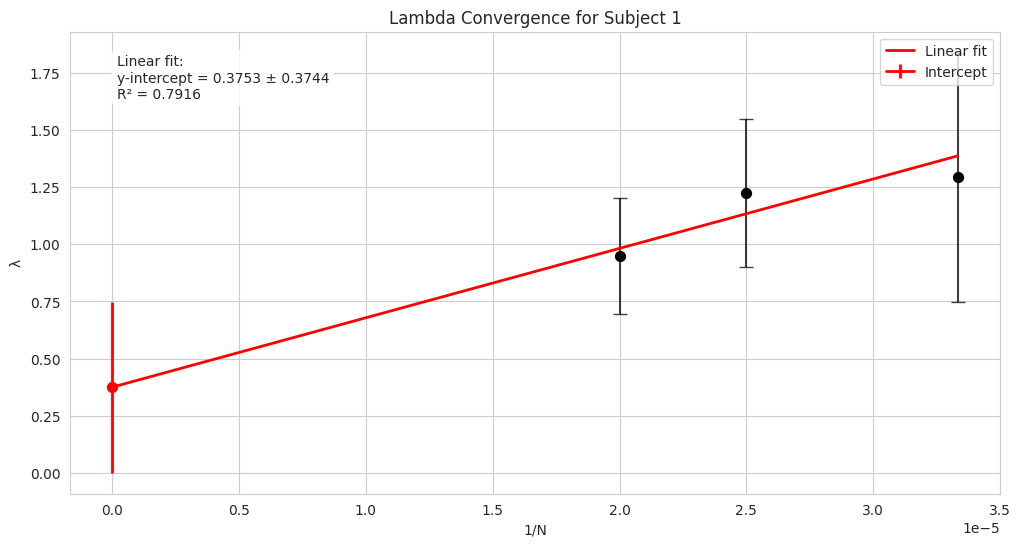

In [511]:
all_results_df = pd.DataFrame()
all_results = []

for eig in range(10):
    results = analyze_lambda_convergence(λs, one_over_n_splits, eig=eig, max_splits=3, max_poly_degree=2)

    # Convert results to DataFrame
    results_df = results_to_dataframe(results)
    results_df["eig"] = eig
    all_results_df = pd.concat([all_results_df, results_df])
    all_results.append(results)

# Plot for a specific subject (e.g., subject 0)
subject = 1
eig = 0
plot_lambda_convergence(λs, one_over_n_splits, all_results[eig], eig=eig, max_splits=3, subject=subject)

In [513]:
all_results_df["AB?"] = all_results_df["Subject"].str[8:].astype(int)<30

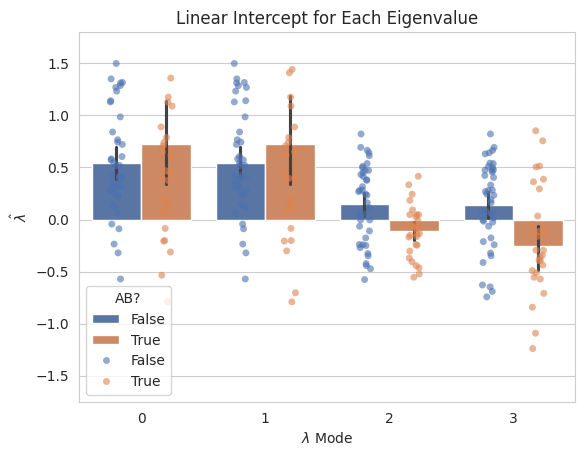

In [514]:
ax = sns.barplot(x="eig", y="Linear_Intercept", hue="AB?", data=all_results_df, palette="deep")
sns.stripplot(x="eig", y="Linear_Intercept", hue="AB?", data=all_results_df, jitter=0.1, alpha=0.6, ax=ax, palette="deep", dodge=True)
plt.xlim(-0.5, 3.5)
plt.ylim(-1.75, 1.8)
plt.xlabel(r"$\lambda$ Mode")
plt.ylabel(r"$\hat{\lambda}$")
plt.title("Linear Intercept for Each Eigenvalue")
plt.show()

In [515]:
all_results_df["Subject"] = all_results_df["Subject"].str[8:].astype(int)
all_results_df.sort_values(["Subject", "eig"], inplace=True)
λs_np = all_results_df.pivot(index="Subject", columns="eig", values="Linear_Intercept").to_numpy()
λs_error_np = all_results_df.pivot(index="Subject", columns="eig", values="Linear_Intercept_StdErr").to_numpy()

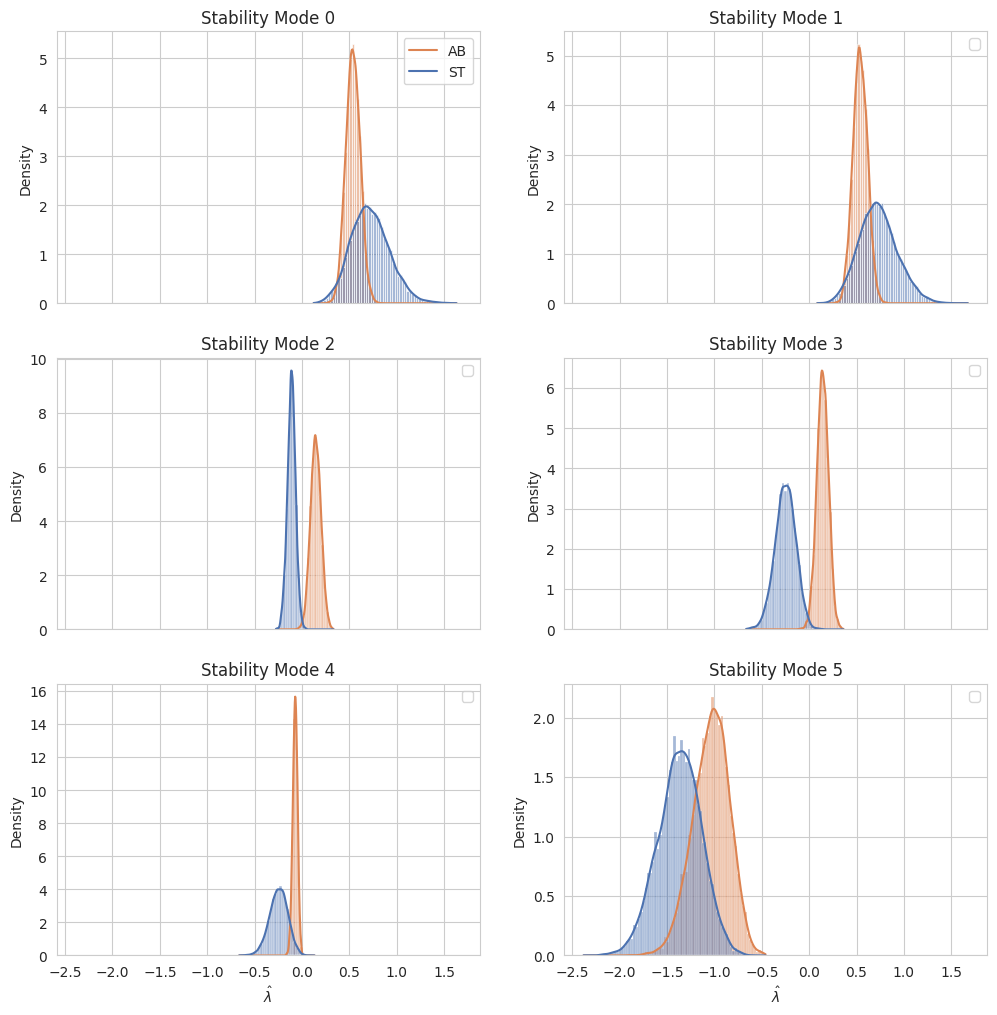

In [520]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
for eig in range(6):
    sample_AB = statistics.get_bootstrapped_sample(λs_np[:30, eig:eig+1])
    sample_ST = statistics.get_bootstrapped_sample(λs_np[30:, eig:eig+1])
    sns.histplot([sample_AB, sample_ST], ax=axs[eig//2, eig%2], stat="density", common_norm=False, kde=True, palette="deep", binwidth=0.025)
    if not eig:
        axs[eig//2, eig%2].legend(["AB", "ST"])
    else:
        axs[eig//2, eig%2].legend([])
    axs[eig//2, eig%2].set_xlabel(r"$\hat{\lambda}$")
    axs[eig//2, eig%2].set_title(f"Stability Mode {eig}")
plt.show()

AB Controls only for this plot: it looks like there are two clearly unstable modes, one that is stable but is very close to instability, and one then the rest are rapidly stabilizing.
If I had to guess, I'd say that the first two modes correspond to the fact that locomotion is a driven dynamical system, and the other modes are primarily used for control and stabilization.

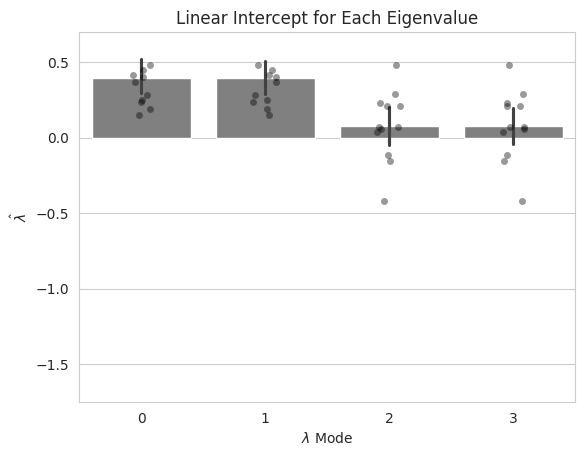

In [417]:
ax = sns.barplot(x="eig", y="Linear_Intercept", data=all_results_df, color="grey")
sns.stripplot(x="eig", y="Linear_Intercept", data=all_results_df, jitter=0.1, alpha=0.4, ax=ax, color="k")
plt.xlim(-0.5, 3.5)
plt.ylim(-1.75, 0.7)
plt.xlabel(r"$\lambda$ Mode")
plt.ylabel(r"$\hat{\lambda}$")
plt.title("Linear Intercept for Each Eigenvalue")
plt.show()